# HSC Amp-to-Amp Offsets

## Useful links
* [LSKs GitHub Repo](https://github.com/leeskelvin/amp2amp)
* [Jira Ticket (DM-20303)](https://jira.lsstcorp.org/browse/DM-20303)
* [Dropbox paper: Background Exploration Aug 2018](https://paper.dropbox.com/doc/Background-Exploration-Aug-2018--ApTKzYDGr98X1Dl_UXBp5iGGAg-62Gc0Msel3yCa6VEtRVy7)
* [Eli's original analysis code](https://raw.githubusercontent.com/leeskelvin/amp2amp/master/ref/compute_and_plot_amp_offsets_pdr1_perpix4.py)
* [Eli's presentation: HSC Background Offsets: What's Up With That?](https://github.com/leeskelvin/amp2amp/blob/master/ref/hsc_background_offsets.pdf)
* [Boone et al. 2018](https://github.com/leeskelvin/amp2amp/blob/master/ref/Boone2018::2018PASP..130f4504B.pdf)

In [59]:
# output options
visit = 1252
outdir = 'singlevisit-ccdplots/visit%05d' % (visit)
rerundir = '/project/lskelvin/hsc-rerun/isrvanilla1252/postISRCCD'
rerunfileglob = '%s/v%07d*/*.fits' % (rerundir, visit)

<h2>HSC CCD Arrangement</h2>
<h3 style="margin-top:10px; margin-bottom:25px;"><a href="https://subarutelescope.org/Observing/Instruments/HSC/ccd.html">https://subarutelescope.org/Observing/Instruments/HSC/ccd.html</a></h3>
<div style="width:700px; height:525px;"><img style="max-width:100%; max-height:100%;" src="ref/CCDPosition_20170212.png" alt="HSC CCDs"></div>

In [21]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
import astropy.io.fits as fits
import esutil
import os.path
from astropy.time import Time
import glob

import lsst
import lsst.afw.math as afwMath
import lsst.daf.persistence as dafPersist

In [204]:
# setup

# directory check
if (not os.path.exists(outdir)):
    os.makedirs(outdir)

# function to rebin 2D array
def rebin(arr, new_shape):
    shape = (int(new_shape[0]), arr.shape[0] // int(new_shape[0]),
             int(new_shape[1]), arr.shape[1] // int(new_shape[1]))
    return arr.reshape(shape).mean(-1).mean(1)

# median absolute deviation
def mad(x, k = 1.4826):
    return k * np.median(np.abs(x - np.median(x)))

# running median
def run_med(x, k = 5):
    runmed = []
    for i in range(len(x)):
        rad = round((k-1)/2)
        xlo = np.max([i-rad,0])
        xhi = np.min([i+rad+1,len(x)])
        runmed.append(np.median(x[xlo:xhi]))
    return runmed

# running mean
def run_mean(x, k = 5):
    runmean = []
    for i in range(len(x)):
        rad = round((k-1)/2)
        xlo = np.max([i-rad,0])
        xhi = np.min([i+rad+1,len(x)])
        runmean.append(np.mean(x[xlo:xhi]))
    return runmean

# log10 image plotting a-la DS9
def aimage(data, scale = 100, scaleLo = None, scaleHi = None, zlim = (None, None), zlo = None, zhi = None):
    # scale limits
    if scaleLo is None and scaleHi is None:
        scaleLo = (100 - scale) / 2
    if scaleLo is None and scaleHi is not None:
        scaleLo = 100 - scaleHi
    if scaleHi is None:
        scaleHi = 100 - scaleLo
    scaleLoDec = scaleLo / 100
    scaleHiDec = scaleHi / 100
    # NOTE: scale is based on pixel distribution (a la DS9), not max/min range of pixel data
    scales = np.quantile(data, (scaleLoDec, scaleHiDec))
    if zlo is None:
        zlo = scales[0]
    if zhi is None:
        zhi = scales[1]
    if zlim[0] is not None:
        zlo = zlim[0]
    if zlim[1] is not None:
        zhi = zlim[1]
    # apply scaling limits
    dataScaled = (data - zlo) / (zhi - zlo)
    dataScaled = np.clip(dataScaled, 0, 1)
    # apply scaling function
    imdat = dataScaled * 500
    fdat = np.log10(imdat + 0.5)
    return fdat

In [201]:
scale = 100
scaleLo = None
scaleHi = None
zlim = (None, None)
zlo = None
zhi = None
# scale limits
if scaleLo is None and scaleHi is None:
    scaleLo = (100 - scale) / 2
if scaleLo is None and scaleHi is not None:
    scaleLo = 100 - scaleHi
if scaleHi is None:
    scaleHi = 100 - scaleLo
scaleLoDec = scaleLo / 100
scaleHiDec = scaleHi / 100
# NOTE: scale is based on pixel distribution (a la DS9), not max/min range of pixel data
scales = np.quantile(data, (scaleLoDec, scaleHiDec))
if zlo is None:
    zlo = scales[0]
if zhi is None:
    zhi = scales[1]
if zlim[0] is not None:
    zlo = zlim[0]
if zlim[1] is not None:
    zhi = zlim[1]

# apply scaling limits
dataScaled = (data - zlo) / (zhi - zlo)
dataScaled = np.clip(dataScaled, 0, 1)

# apply scaling function
imdat = dataScaled * 500
fdat = np.log10(imdat + 0.5)
flo = np.log10(0.5)
fhi = np.log10(1.5)

In [219]:
rerundata.shape

(4176, 2048)

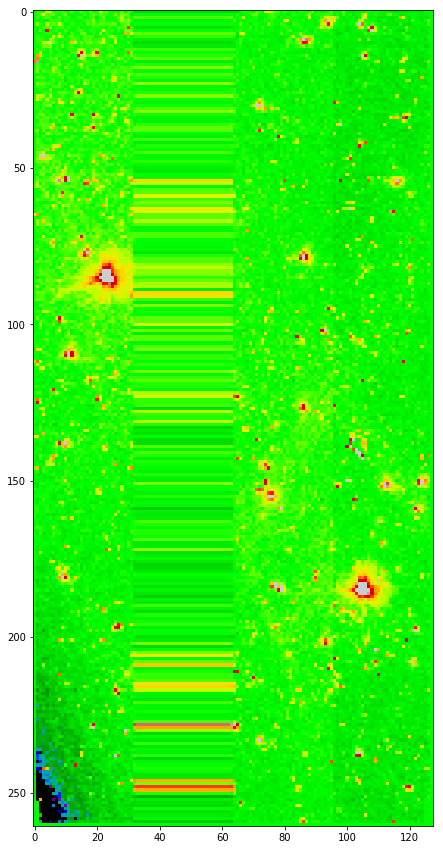

In [221]:
plt.figure(figsize=(15,15))
plt.imshow(aimage(rebin(rerundata,(4176/16, 2048/16)), scale=99.5), cmap='nipy_spectral')
plt.show()

In [4]:
# butler
butlerVisit = dafPersist.Butler(
    '/datasets/hsc/repo/rerun/private/erykoff/fgcm_pdr1_run1wd/wide_deep2'
)
obsTable = butlerVisit.get(
    'fgcmVisitCatalog'
)
butler = dafPersist.Butler(
    '/datasets/hsc/repo/rerun/private/erykoff/hscproc/runIsrPDR1'
)

In [5]:
# generate camera table, containing all amplifier raw imaging data
camera = butler.get('camera')
temp_ids = []
temp_amps = []
for ccd in range(len(camera)):
    temp_ids.append(camera[ccd].getId())
    temp_amps.append(camera[ccd].getAmplifiers())
ccds = dict(zip(temp_ids, temp_amps))

In [96]:
i=0
rerunfile = basedir + '/c%03d.fits' % (camera[i].getId())
rerunfile

'/project/lskelvin/hsc-rerun/isrvanilla1252/postISRCCD/v0001252-fHSC-I/c000.fits'

In [120]:
rerunfile = basedir + '/c%03d.fits' % (camera[i].getId())
rerundata = fits.getdata(rerunfile)
test = rerundata[0:100,0:100]

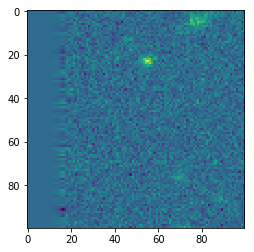

In [121]:
#%matplotlib inline
plt.imshow(np.log10(test))
plt.show()

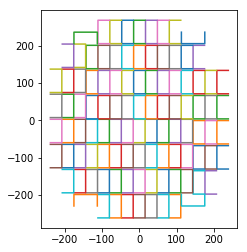

In [79]:
# generate focal plane plot
reruns = sorted(glob.glob(rerunfileglob, recursive=True))
basedir = os.path.dirname(reruns[0])

for i in range(len(camera)):
    
    # rerun CCD image
    rerunfile = basedir + '/c%03d.fits' % (camera[i].getId())
    rerundata = fits.getdata(rerunfile)
    
    if os.path.exists(rerunfile):
        
        # get CCD image
        hdu_list = fits.open(rerunfile)
        image_data = hdu_list[0].data
        hdu_list.close()
        
        pixToFocal = camera[i].getTransform(lsst.afw.cameraGeom.PIXELS, lsst.afw.cameraGeom.FOCAL_PLANE)
        corners = pixToFocal.applyForward(camera[i].getCorners(lsst.afw.cameraGeom.PIXELS))
        plt.plot(*zip(*corners))
        plt.gca().set_aspect('equal', adjustable='box')

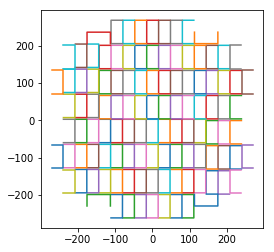

In [8]:
for i in range(len(camera)):
    pixToFocal = camera[i].getTransform(lsst.afw.cameraGeom.PIXELS, lsst.afw.cameraGeom.FOCAL_PLANE)
    corners = pixToFocal.applyForward(camera[i].getCorners(lsst.afw.cameraGeom.PIXELS))
    plt.plot(*zip(*corners))
    #centers = pixToFocal.applyForward(camera[i].getCenter(lsst.afw.cameraGeom.PIXELS))
    #plt.plot(centers[0], centers[1], 'bo')
    plt.gca().set_aspect('equal', adjustable='box')

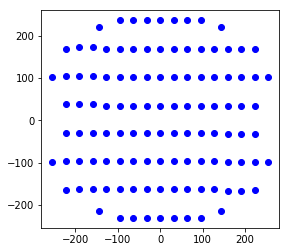

In [9]:
for i in range(len(camera)):
    pixToFocal = camera[i].getTransform(lsst.afw.cameraGeom.PIXELS, lsst.afw.cameraGeom.FOCAL_PLANE)
    #corners = pixToFocal.applyForward(camera[i].getCorners(lsst.afw.cameraGeom.PIXELS))
    #plt.plot(*zip(*corners), 'bo')
    centers = pixToFocal.applyForward(camera[i].getCenter(lsst.afw.cameraGeom.PIXELS))
    plt.plot(centers[0], centers[1], 'bo')
    plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
# generate 

In [20]:
# define amps
camera = butler.get('camera')
det = camera[ccd]
amp1, amp2, amp3, amp4 = det.getAmplifiers()

KeyError: 'ccd'

In [6]:
# raw data bounding boxes
dbox1 = amp1.getRawDataBBox()
dbox2 = amp2.getRawDataBBox()
dbox3 = amp3.getRawDataBBox()
dbox4 = amp4.getRawDataBBox()

In [7]:
# horizontal overscan bounding boxes
obox1 = amp1.getRawHorizontalOverscanBBox()
obox2 = amp2.getRawHorizontalOverscanBBox()
obox3 = amp3.getRawHorizontalOverscanBBox()
obox4 = amp4.getRawHorizontalOverscanBBox()

In [8]:
# obsTable data
filtername = [d['filtername'] for d in np.asarray(obsTable)]
if band != 'all': 
    goodfilters = [i for i,s in enumerate(filtername) if band in s]
    filtername = np.asarray(filtername)[goodfilters]
else: 
    goodfilters = range(len(filtername))
filtername = np.array(filtername)
visits = obsTable['visit'][goodfilters]
exptime = obsTable['exptime'][goodfilters]
skybackground = obsTable['skybackground'][goodfilters]
mjd = obsTable['mjd'][goodfilters]
t = Time(mjd, format="mjd")
obsdate = t.decimalyear
ufname,ufcount = np.unique(filtername, return_counts=True)
print('\033[1m')
print('Number of visits:', visits.size)
print('Number of visits by filter:', dict(zip(ufname,ufcount)))
print('Number of pixel rows:', dbox1.getHeight())
print('Exposure time range:', '[', "%.0f" % np.min(exptime), ':', "%.0f" % np.max(exptime), ']')
print('Sky background range:', '[', "%.2f" % np.min(skybackground), ':', "%.2f" % np.max(skybackground), ']')
print('Date of Obs. range:', '[', "%.2f" % np.min(obsdate), ':', "%.2f" % np.max(obsdate), ']')
print('\033[0m')


Number of visits: 5190
Number of visits by filter: {'g': 1030, 'i': 1041, 'r': 925, 'y': 1032, 'z': 1162}
Number of pixel rows: 4176
Exposure time range: [ 30 : 270 ]
Sky background range: [ 56.01 : 14375.22 ]
Date of Obs. range: [ 2014.23 : 2015.87 ]



In [9]:
# image of CCD data regions for single visit

# setup
devscale = 2 # number of stdevs/madevs to plot either side
readme = open('%s/README.md' % outdir, 'w')
readme.write("# CCD %s Visit Plots\n" % ccd)

# visit list
ids = np.array(np.where(np.array(filtername) == 'g')).tolist()[0][0:20]
ids.extend(np.array(np.where(np.array(filtername) == 'r')).tolist()[0][0:20])
ids.extend(np.array(np.where(np.array(filtername) == 'i')).tolist()[0][0:20])
ids.extend(np.array(np.where(np.array(filtername) == 'z')).tolist()[0][0:20])
ids.extend(np.array(np.where(np.array(filtername) == 'y')).tolist()[0][0:20])

# loop
counter = 0
for imvisit, imfilter in zip(visits[ids], filtername[ids]):
    
    # counter
    counter += 1
    if (counter % 20) == 0:
        print('On %d of %d' % (counter, len(ids)))
    
    # setup
    doutname = '%s/ccd%03d_visit%s_%s_data.png' % (outdir, ccd, imvisit, imfilter)
    ooutname = '%s/ccd%03d_visit%s_%s_overscan.png' % (outdir, ccd, imvisit, imfilter)
    
    # write README file
    readme.write("### CCD %s: visit %s, filter %s" % (ccd, imvisit, imfilter))
    readme.write("![](%s)\n" % os.path.split(doutname)[1])
    readme.write("![](%s)\n" % os.path.split(ooutname)[1])
    
    # check files exist
    if ( (not os.path.exists(doutname)) or (not os.path.exists(ooutname)) ):
        
        # butler
        raw = butler.get('raw', visit=int(imvisit), ccd=ccd)
        
        # get map for each data region (converted to int64)
        data1 = raw.maskedImage[dbox1].getArrays()[0].astype(np.int64)
        data2 = raw.maskedImage[dbox2].getArrays()[0].astype(np.int64)
        data3 = raw.maskedImage[dbox3].getArrays()[0].astype(np.int64)
        data4 = raw.maskedImage[dbox4].getArrays()[0].astype(np.int64)
        
        # get map for each horizontal overscan region (converted to int64)
        overscan1 = raw.maskedImage[obox1].getArrays()[0].astype(np.int64)
        overscan2 = raw.maskedImage[obox2].getArrays()[0].astype(np.int64)
        overscan3 = raw.maskedImage[obox3].getArrays()[0].astype(np.int64)
        overscan4 = raw.maskedImage[obox4].getArrays()[0].astype(np.int64)
        
        # rebin, log, subtract mean/median, rescale to std/mad, and rotate
        ddownscale = 4
        mdata = []
        for data in [data1, data2, data3, data4]:
            temp = np.log10(rebin(data, new_shape=tuple(np.array(data.shape)/ddownscale)))
            temp -= np.median(temp)
            temp /= mad(temp)
            temp = np.rot90(temp)
            mdata.append(temp)
        
        # rebin, subtract mean/median, rescale to std/mad, and rotate
        odownscale = 24
        moverscan = []
        for overscan in [overscan1, overscan2, overscan3, overscan4]:
            temp = rebin(overscan, new_shape=(np.array(overscan.shape)[0]/odownscale, np.array(overscan.shape)[1]))
            temp -= np.median(temp)
            temp /= mad(temp)
            temp = np.rot90(temp)
            moverscan.append(temp)
        
        # data plot setup
        fig = plt.figure(constrained_layout=False, figsize=(13,6.5), dpi=300)
        spec = plt.GridSpec(ncols=25, nrows=4, figure=fig)
        ax1 = fig.add_subplot(spec[0, 0:-3])
        ax2 = fig.add_subplot(spec[1, 0:-3])
        ax3 = fig.add_subplot(spec[2, 0:-3])
        ax4 = fig.add_subplot(spec[3, 0:-3])
        ax0 = fig.add_subplot(spec[:, -1])
        axs = [ax4, ax3, ax2, ax1]

        # data plot plotting
        for i, mod, orig in zip([0,1,2,3], mdata, [data1,data2,data3,data4]):
            im = axs[i].imshow(mod, vmin=-devscale, vmax=devscale)
            axs[i].set_axis_off()
            axs[i].text(1.05, 0.5, "amp %s" % (i+1), 
                        horizontalalignment='center', verticalalignment='center', transform = axs[i].transAxes, 
                        fontsize=12, rotation=-90)
            axs[i].text(1.03, 0.5, "med = %.0f" % np.median(orig), 
                        horizontalalignment='center', verticalalignment='center', transform = axs[i].transAxes, 
                        fontsize=8, rotation=-90)
            axs[i].text(1.01, 0.5, "log(MAD) = %.4f" % mad(np.log10(orig)), 
                        horizontalalignment='center', verticalalignment='center', transform = axs[i].transAxes, 
                        fontsize=8, rotation=-90)

        # colorbar
        fig.colorbar(im, cax=ax0)
        ax0.text(3, 0.5, "log MAD offset from median", 
                 horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, 
                 fontsize=14, rotation=-90)

        # data plot finish up
        fig.text(0.5, 0.91, "CCD %s data: visit %s, filter %s" % (ccd, imvisit, imfilter), 
                 horizontalalignment='center', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=16)
        fig.text(0.15, 0.09, "y pixel position / %s ⟶" % ddownscale, 
                 horizontalalignment='left', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=14)
        fig.text(0.11, 0.16, "⟵ x pixel position / %s" % ddownscale, 
                 horizontalalignment='center', verticalalignment='bottom', transform = fig.transFigure, 
                 fontsize=14, rotation=-90)
        plt.savefig(doutname, dpi='figure')
        plt.close(fig)
        
        # overscan plot setup
        fig = plt.figure(constrained_layout=False, figsize=(13,11), dpi=300)
        spec = plt.GridSpec(ncols=25, nrows=8, figure=fig)
        ax1a = fig.add_subplot(spec[1, :-3])
        ax1d = fig.add_subplot(spec[0, :-3])
        ax1h = fig.add_subplot(spec[1, -3:-1])
        ax2a = fig.add_subplot(spec[3, :-3])
        ax2d = fig.add_subplot(spec[2, :-3])
        ax2h = fig.add_subplot(spec[3, -3:-1])
        ax3a = fig.add_subplot(spec[5, :-3])
        ax3d = fig.add_subplot(spec[4, :-3])
        ax3h = fig.add_subplot(spec[5, -3:-1])
        ax4a = fig.add_subplot(spec[7, :-3])
        ax4d = fig.add_subplot(spec[6, :-3])
        ax4h = fig.add_subplot(spec[7, -3:-1])
        ax0 = fig.add_subplot(spec[:, -1])
        axsa = [ax4a, ax3a, ax2a, ax1a]
        axsd = [ax4d, ax3d, ax2d, ax1d]
        axsh = [ax4h, ax3h, ax2h, ax1h]

        # overscan plot plotting
        for i, mod, orig, over0, over1 in zip([0,1,2,3], moverscan, [overscan1,overscan2,overscan3,overscan4], 
                                              [overscan1[:, 0],overscan2[:, -1],overscan3[:, 0],overscan4[:, -1]], 
                                              [overscan1[:, -1],overscan2[:, 0],overscan3[:, -1],overscan4[:, 0]]
                                             ):

            # 2D plot
            im = axsa[i].imshow(mod, vmin=-devscale, vmax=devscale)
            axsa[i].set_axis_off()
            axsa[i].text(0, 1.17, "amp %s" % (i+1), 
                         horizontalalignment='left', verticalalignment='center', transform = axsa[i].transAxes, 
                         fontsize=12, rotation=0)
            axsa[i].text(0.075, 1.17, "med = %.0f" % np.median(orig), 
                         horizontalalignment='left', verticalalignment='center', transform = axsa[i].transAxes, 
                         fontsize=12, rotation=0)
            axsa[i].text(0.205, 1.17, "MAD = %.3f" % mad(orig), 
                         horizontalalignment='left', verticalalignment='center', transform = axsa[i].transAxes, 
                         fontsize=12, rotation=0)

            # delta overscan line plot
            t0 = (over0 - np.median(orig)) / mad(orig)
            t1 = (over1 - np.median(orig)) / mad(orig)
            axsd[i].set_ylim([-3.5,3.5])
            #axsd[i].yaxis.set_major_locator(plt.MaxNLocator(3))
            axsd[i].set_yticks([-2,-1,0,1,2])
            #axsd[i].set_yticklabels([])
            axsd[i].yaxis.tick_right()
            axsd[i].yaxis.set_ticks_position('none')
            axsd[i].margins(x=0, y=0)
            axsd[i].axes.get_xaxis().set_visible(False)
            axsd[i].xaxis.set_ticks_position('none')
            axsd[i].set_xticklabels([])
            axsd[i].spines['top'].set_visible(False)
            axsd[i].spines['bottom'].set_visible(False)
            axsd[i].spines['left'].set_visible(False)
            axsd[i].spines['right'].set_visible(False)
            #axsd[i].plot(np.linspace(0, 1, num=len(over0)), over1-over0, color='#998ec3')
            axsd[i].plot(np.linspace(0, 1, num=len(over0)), run_mean(t0-t1, k=odownscale+1), 
                         linewidth=3, color='#f1a340')
            axsd[i].grid(color='grey', linestyle='dotted')
            axsd[i].axhline(y=0, color='black')
            axsd[i].tick_params(labelsize=8)
            axsd[i].text(1.04, 0.5, "Δₒ / MAD", 
                         horizontalalignment='center', verticalalignment='center', transform = axsd[i].transAxes, 
                         fontsize=10, rotation=-90)

            # collapsed 2D line plot
            #axsh[i].axvline(x=0, color='black')
            axsh[i].plot((np.mean(orig, axis=0) - np.median(orig)) / mad(orig), range(16), 
                         linewidth=5, color='#998ec3')
            axsh[i].set_ylim([-1,16])
            axsh[i].set_xlim([-2.5,2.5])
            axsh[i].margins(x=0, y=0)
            axsh[i].grid(color='grey', linestyle='dotted')
            axsh[i].spines['top'].set_visible(False)
            axsh[i].spines['bottom'].set_visible(False)
            axsh[i].spines['left'].set_visible(False)
            axsh[i].spines['right'].set_visible(False)
            #axsh[i].set_xticklabels([])
            #axsh[i].set_yticklabels([])
            #axsh[i].yaxis.set_ticks_position('none')
            #axsh[i].xaxis.set_major_locator(plt.MaxNLocator(3))
            axsh[i].set_xticks([-2,-1,0,1,2])
            #axsh[i].xaxis.tick_top()
            axsh[i].xaxis.set_ticks_position('none')
            axsh[i].axes.get_yaxis().set_visible(False)
            axsh[i].tick_params(labelsize=8)
            if i == 0:
                axsh[i].text(0.5, -0.35, "Σf / MAD", 
                             horizontalalignment='center', verticalalignment='center', transform = axsh[i].transAxes, 
                             fontsize=10, rotation=0)

        # colorbar
        fig.colorbar(im, cax=ax0)
        ax0.text(3, 0.5, "MAD offset from median", 
                 horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, 
                 fontsize=14, rotation=-90)

        # overscan plot finish up
        fig.text(0.5, 0.91, "CCD %s overscan: visit %s, filter %s" % (ccd, imvisit, imfilter), 
                 horizontalalignment='center', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=16)
        fig.text(0.14, 0.1, "y pixel position / %s ⟶" % odownscale, 
                 horizontalalignment='left', verticalalignment='center', transform = fig.transFigure, 
                 fontsize=14)
        fig.text(0.105, 0.15, "⟵ x pixel position", 
                 horizontalalignment='center', verticalalignment='bottom', transform = fig.transFigure, 
                 fontsize=14, rotation=-90)
        plt.savefig(ooutname, dpi='figure')
        plt.close(fig)

# finish up
readme.close()

On 20 of 100
On 40 of 100
On 60 of 100
On 80 of 100
On 100 of 100


In [10]:
print("\033[1mall done!\033[0m")

all done!
